# Mini Project - Spam Email Classifier

### Importing libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Reading the data

In [48]:
data = pd.read_csv("Datasets/SMSSpamCollection", sep='\t', header=None, names = ['label', 'sms'])
data.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploring the dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
data.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


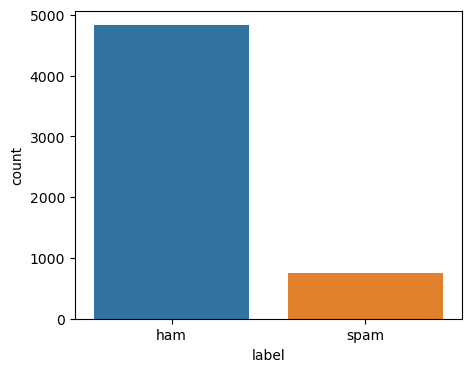

In [9]:
plt.figure(figsize = (5,4))
sns.countplot(x = 'label', data = data);

### Cleaning the data

In [12]:
snowball = SnowballStemmer("english")
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

#### Function to clean the text (snowball stemmer is used)

In [38]:
def clean_text(sms):
    sms = sms.lower()   # converting the input to lowercase
    sms = re.sub("[^a-z0-9]", " ", sms)   # removing everything except letters and numbers
    sms = re.sub(r'\s+', ' ', sms).strip()  # removing leading, trailing and in between extra spaces from input
    
    sms = nltk.word_tokenize(sms)       # tokenizing the words
    sms = [word for word in sms if len(word)>1]    # removing words of length 1
    sms = [snowball.stem(word) for word in sms if word not in stop_words] # removing stopwords & stemming using snowball stemmer
    sms = " ".join(sms)   # joing the strings to form text
    return sms
    
clean_text("Hi, WE HAVE AN OFFER for you!!! Click here to have 100000 in your bank account and start shopping!")

'hi offer click 100000 bank account start shop'

#### Function to clean the text (porter stemmer is used)

In [40]:
def clean_text_v2(sms):
    sms = sms.lower()   # converting the input to lowercase
    sms = re.sub("[^a-z0-9]", " ", sms)   # removing everything except letters and numbers
    sms = re.sub(r'\s+', ' ', sms).strip()  # removing leading, trailing and in between extra spaces from input
    
    sms = nltk.word_tokenize(sms)       # tokenizing the words
    sms = [word for word in sms if len(word)>1]    # removing words of length 1
    sms = [porter.stem(word) for word in sms if word not in stop_words] # removing stopwords & stemming using porter stemmer
    sms = " ".join(sms)   # joing the strings to form text
    return sms
    
clean_text("Hi, WE HAVE AN OFFER for you!!! Click here to have 100000 in your bank account and start shopping!")

'hi offer click 100000 bank account start shop'

In [51]:
data['cleaned_sms'] = data['sms'].apply(clean_text)

In [52]:
data.head()

,label,sms,cleaned_sms
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi great world l...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


### Wordcloud

In [70]:
ham_sms = data[data['label'] == 'ham']['cleaned_sms']
ham_sms.head()

0    go jurong point crazi avail bugi great world l...
1                                  ok lar joke wif oni
3                        dun say earli hor alreadi say
4                 nah think goe usf live around though
6        even brother like speak treat like aid patent
Name: cleaned_sms, dtype: object

In [71]:
spam_sms = data[data['label'] == 'spam']['cleaned_sms']
spam_sms.head()

2     free entri wkli comp win fa cup final tkts 21s...
5     freemsg hey darl week word back like fun still...
8     winner valu network custom select receivea 900...
9     mobil 11 month entitl updat latest colour mobi...
11    six chanc win cash 100 20 000 pound txt csh11 ...
Name: cleaned_sms, dtype: object

In [69]:
def generate_wordcloud(text):
    text = " ".join(text)
    wc = WordCloud(background_color='white')
    wc = wc.generate(text)
    
    plt.figure(figsize=(10,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

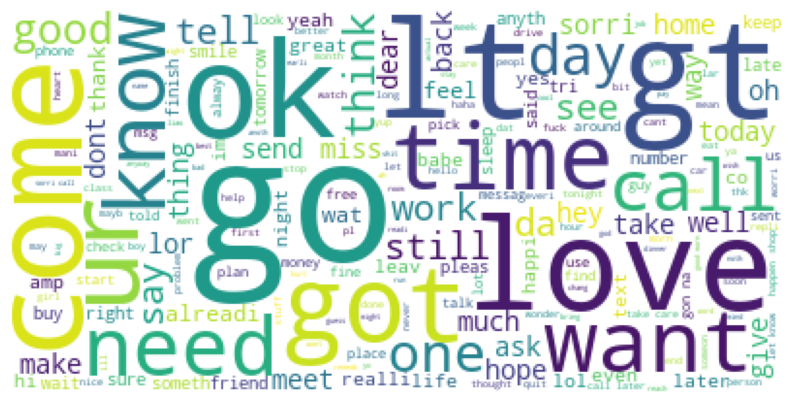

In [72]:
generate_wordcloud(ham_sms)

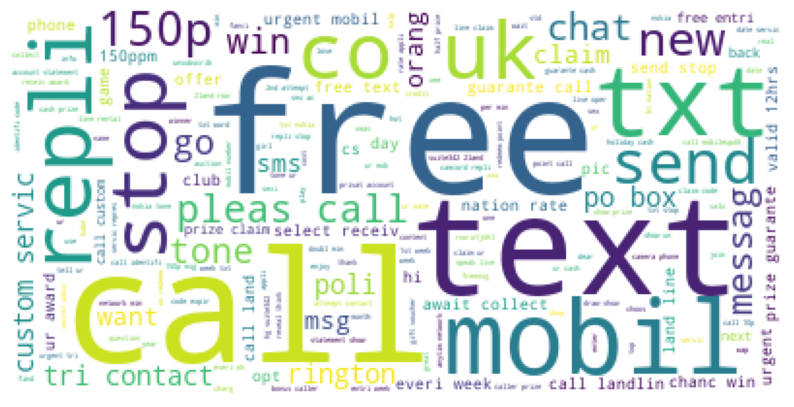

In [73]:
generate_wordcloud(spam_sms)

### Converting text data to features

In [77]:
data.head()

,label,sms,cleaned_sms
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi great world l...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [78]:
data['label'] = data['label'].apply(lambda x: 0 if x == 'ham' else 1)

In [79]:
data.head()

,label,sms,cleaned_sms
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi great world l...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


#### Splitting the dataset into X and y

In [81]:
X = data['cleaned_sms']
y = data['label']

#### Splitting the dataset into training and testing set to avoid leakage while fitting feature transformation models

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [86]:
X_train.shape, y_train.shape

((3900,), (3900,))

In [87]:
X_test.shape, y_test.shape

((1672,), (1672,))

#### Vectorized the text dataset

In [90]:
vectorizer = CountVectorizer(max_features=5000)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [91]:
X_train_vectorized.shape, y_train.shape

((3900, 5000), (3900,))

In [92]:
X_test_vectorized.shape, y_test.shape

((1672, 5000), (1672,))

In [97]:
X_train_vectorized = X_train_vectorized.toarray()
X_train_vectorized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [98]:
X_test_vectorized = X_test_vectorized.toarray()
X_test_vectorized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Model building

In [100]:
logistic_cf = LogisticRegression()
knn_cf = KNeighborsClassifier(n_neighbors=5)
multinomial_nb_cf = MultinomialNB()
bernoulli_nb_cf = BernoulliNB()

In [101]:
logistic_cf.fit(X_train_vectorized, y_train)
knn_cf.fit(X_train_vectorized, y_train)
multinomial_nb_cf.fit(X_train_vectorized, y_train)
bernoulli_nb_cf.fit(X_train_vectorized, y_train)

BernoulliNB()

In [103]:
y_pred_train_logistic = logistic_cf.predict(X_train_vectorized)
y_pred_train_knn = knn_cf.predict(X_train_vectorized)
y_pred_train_multinb = multinomial_nb_cf.predict(X_train_vectorized)
y_pred_train_bernoullinb = bernoulli_nb_cf.predict(X_train_vectorized)

In [102]:
y_pred_test_logistic = logistic_cf.predict(X_test_vectorized)
y_pred_test_knn = knn_cf.predict(X_test_vectorized)
y_pred_test_multinb = multinomial_nb_cf.predict(X_test_vectorized)
y_pred_test_bernoullinb = bernoulli_nb_cf.predict(X_test_vectorized)

In [111]:
def accuracy_score(model, X_train, X_test, y_train, y_test, return_acc = 0):
    train_acc = round((model.score(X_train, y_train))*100,2)
    test_acc = round((model.score(X_test, y_test))*100,2)
    print(f"Training Accuray from {type(model).__name__}: {train_acc}%")
    print(f"Test Accuray from {type(model).__name__}: {test_acc}%")
    
    if return_acc:
        return train_acc, test_acc

In [112]:
accuracy_score(logistic_cf,
               X_train = X_train_vectorized, 
               X_test= X_test_vectorized,
               y_train=y_train,
               y_test=y_test,
               return_acc=0)

Training Accuray from LogisticRegression: 99.59%
Test Accuray from LogisticRegression: 98.33%


In [113]:
accuracy_score(knn_cf,
               X_train = X_train_vectorized, 
               X_test= X_test_vectorized,
               y_train=y_train,
               y_test=y_test,
               return_acc=0)

Training Accuray from KNeighborsClassifier: 92.49%
Test Accuray from KNeighborsClassifier: 92.05%


In [110]:
accuracy_score(multinomial_nb_cf,
               X_train = X_train_vectorized, 
               X_test= X_test_vectorized,
               y_train=y_train,
               y_test=y_test,
               return_acc=0)

Training Accuray from MultinomialNB: 99.26%
Test Accuray from MultinomialNB: 98.62%


In [114]:
accuracy_score(bernoulli_nb_cf,
               X_train = X_train_vectorized, 
               X_test= X_test_vectorized,
               y_train=y_train,
               y_test=y_test,
               return_acc=0)

Training Accuray from BernoulliNB: 98.74%
Test Accuray from BernoulliNB: 97.85%


Credits: https://www.udemy.com/course/machine-learning-artificial-intelligence-essentials